# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1MnXcdsV1WCEvk-cFH54LjmePa0P1uQ_8#scrollTo=8ns99-jbRB13

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:29tcmalloc: large alloc 1147494400 bytes == 0x3abb4000 @  0x7fe4a7d61615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████████████████               | 1055.7 MB 1.7 MB/s eta 0:09:11tcmalloc: large alloc 1434370048 bytes == 0x7f20a000 @  0x7fe4a7d61615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [3]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ONLY NEED TO DO THIS UNZIPPING ONE TIME
# Unzip the dataset.zip file
#!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/smsspamcollection.zip' -d '/content/drive/MyDrive/Colab Notebooks/APS360/smsspam_dataset'

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [5]:
first_ham = True
for line in open('/content/drive/MyDrive/Colab Notebooks/APS360/smsspam_dataset/SMSSpamCollection'):
    if first_ham and line.split()[0] == 'ham':
      print("The label value for a non-spam message:", line.split()[0])
      print("Example of a non-spam: ", line)
      first_ham = False
    elif not first_ham and line.split()[0] == 'spam':
      print("The label value for a spam message:", line.split()[0])
      print("Example of a spam: ", line)
      break

The label value for a non-spam message: ham
Example of a non-spam:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

The label value for a spam message: spam
Example of a spam:  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [6]:
spam_count, ham_count = 0, 0

for line in open('/content/drive/MyDrive/Colab Notebooks/APS360/smsspam_dataset/SMSSpamCollection'):
  if line.split()[0] == 'spam':
    spam_count += 1
  else:
    ham_count += 1

print('The total number of spam messages are:', spam_count)
print('The total number of non-spam messages are:', ham_count)

The total number of spam messages are: 747
The total number of non-spam messages are: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

The advantages of modelling SMS text messages as a sequence of characters rather than a sequence of words are:

1.   Can account for misspelled words, processing abreviations and slang words
2.   Can save a lot of memory. This is due to the limited number of characters that are available. Saving word sequences uses a lot more memory because there is a vast word pool available. This implies that the processing of a sequence of characters proceeds more quickly than the processing of a sequence of words.

Disdvantages of modelling SMS text messages as a sequence of characters rather than a sequence of words are:

1.   It is harder to understand context and meaning from a sequence of characters than it would be for a sequence of words.
2.   A larger hidden layer is required to process each character rather than just processing the entire word.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [10]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("/content/drive/MyDrive/Colab Notebooks/APS360/smsspam_dataset/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

print(dataset[0].sms)
print(dataset[0].label)

train, valid, test = dataset.split([0.6, 0.2, 0.2], True)

print("The length of training data:", len(train))
print("The length of validation data:", len(valid))
print("The length of testing data:", len(test))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0
The length of training data: 3343
The length of validation data: 1115
The length of testing data: 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [11]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

spam_count = len(train_spam) * 6

print("The new length of training set:", len(train.examples))
print("The new count of spam in the training set:", spam_count)
print("The new count of spam in the training set:", len(train.examples) - spam_count, '\n')

The new length of training set: 6031
The new count of spam in the training set: 2688
The new count of spam in the training set: 3343 



It is quite beneficial to have a balanced training set to help our neural network become bias-free. Presently, only 4827 of the 5574 total samples are non-spam, creating an unbalanced training set. As a result, the neural network can presently guess non-spam with an accuracy of 86.6%. Even with such high accuracy, our model is not particularly effective. Simply put, it indicates that the algorithm is selecting the alternative that outperformed our data. By balancing the training set and exposing the model to an equal number of spam and non-spam messages, the model can actually learn to distinguish between the two, improving its ability to identify spam.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [12]:
text_field.build_vocab(train)
text_field.vocab.stoi
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 'd',
 '0',
 '.',
 'c',
 'm',
 'y',
 'w',
 'p',
 'g',
 'f',
 '1',
 '2',
 'b',
 'T',
 '8',
 'k',
 'E',
 'S',
 'v',
 'O',
 '5',
 'I',
 'C',
 '4',
 'A',
 'N',
 'x',
 '7',
 '6',
 'R',
 '3',
 '!',
 ',',
 'P',
 '9',
 'M',
 'U',
 'W',
 'H',
 'L',
 'D',
 'F',
 'Y',
 'B',
 'G',
 "'",
 '/',
 '?',
 '£',
 '&',
 '-',
 ':',
 'X',
 'V',
 'z',
 '*',
 'K',
 'j',
 ')',
 ';',
 'J',
 '+',
 '(',
 'q',
 '"',
 '#',
 'Q',
 '=',
 '@',
 'Z',
 'ü',
 '>',
 '%',
 '$',
 'Ü',
 '‘',
 '|',
 '<',
 '\x92',
 '“',
 '_',
 '…',
 '[',
 ']',
 '\x93',
 'é',
 '–',
 '\\',
 '\x91',
 '\x94',
 '\x96',
 '’',
 'É',
 'è',
 'ì',
 '—',
 '┾',
 '〨',
 '鈥']

The variable text_field.vocab.stoi represents the mapping of strings to numerical identifiers. In this case, each of the characters is mapped to a number.

The variable text_field.vocab.itos represents the strings indexed by their numerical identifiers. In this case, this is the list of characters in stoi with the same order.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents unknown characters.
`<pad>` represents the padding token which is used to increase the size of the data items.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [13]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [44]:
count = 0
for batch in train_iter:
    if count >= 10:
      break
    else:
      max_len = max(batch.sms[1]).item()
      print("The batch number is:", count)
      print("The max length of the input sequence in this batch is:", max_len)

      padSum = 0
      for message in batch.sms[0]:
        for pad in message:
          if pad == 1:
            padSum += 1
      print("The count of <pad> is:", padSum, '\n')
      count += 1

The batch number is: 0
The max length of the input sequence in this batch is: 39
The count of <pad> is: 21 

The batch number is: 1
The max length of the input sequence in this batch is: 52
The count of <pad> is: 19 

The batch number is: 2
The max length of the input sequence in this batch is: 45
The count of <pad> is: 29 

The batch number is: 3
The max length of the input sequence in this batch is: 35
The count of <pad> is: 22 

The batch number is: 4
The max length of the input sequence in this batch is: 30
The count of <pad> is: 11 

The batch number is: 5
The max length of the input sequence in this batch is: 59
The count of <pad> is: 33 

The batch number is: 6
The max length of the input sequence in this batch is: 105
The count of <pad> is: 62 

The batch number is: 7
The max length of the input sequence in this batch is: 28
The count of <pad> is: 26 

The batch number is: 8
The max length of the input sequence in this batch is: 27
The count of <pad> is: 33 

The batch number i

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [16]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [17]:
class SpamDetectionRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamDetectionRNN, self).__init__()
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first= True)
    self.fc = nn.Linear(hidden_size*2, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.emb[x]
    # Set an initial hidden state
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward pass propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output from the last time step to the classifier
    out = self.fc(torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1))
    return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [22]:
def get_accuracy(model, data, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    # Setting up the data loader
    # Minimizing padding. Sorting within each batch. Not repeating the iterator for many epochs
    dataLoader = torchtext.legacy.data.BucketIterator(data, batch_size=batch_size, sort_key= lambda x: len(x.sms),
                                               sort_within_batch = True, repeat = False)

    correct, total = 0, 0

    for messages, labels in dataLoader:
      output = model(messages[0])
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(labels.view_as(prediction)).sum().item()
      total += labels.shape[0]

    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [26]:
def trainRNN(model, training, validation, batch_size=64, num_epochs=15, learning_rate= 1e-4):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  training_losses, validation_losses, training_accuracy, validation_accuracy = [], [], [], []
  epochs = []

  trainingLoader = torchtext.legacy.data.BucketIterator(training, batch_size=batch_size, sort_key= lambda x: len(x.sms),
                                               sort_within_batch = True, repeat = False)
  
  validationLoader = torchtext.legacy.data.BucketIterator(validation, batch_size=batch_size, sort_key= lambda x: len(x.sms),
                                               sort_within_batch = True, repeat = False)

  for epoch in range(num_epochs):
    for messages, labels in trainingLoader:
      optimizer.zero_grad()
      prediction = model(messages[0])
      loss = criterion(prediction, labels)
      loss.backward()
      optimizer.step()
    training_losses.append(float(loss))

    for messages, labels in validationLoader:
      prediction = model(messages[0])
      loss = criterion(prediction, labels)
    validation_losses.append(float(loss))

    epochs.append(epoch)
    
    training_accuracy.append(get_accuracy(model, training, batch_size))
    validation_accuracy.append(get_accuracy(model, validation, batch_size))

    print("Epoch:", epoch + 1, ", Training Accuracy:", training_accuracy[-1], ", Validation Accuracy:", validation_accuracy[-1])


  #Accuracy Plot
  plt.title("Training Curve")
  plt.plot(training_accuracy, label='Training')
  plt.plot(validation_accuracy, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.show()

  #Loss Plot
  plt.title('Training Curve')
  plt.plot(training_losses, label='Training')
  plt.plot(validation_losses, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.show()


Epoch: 1 , Training Accuracy: 0.5015751948267285 , Validation Accuracy: 0.820627802690583
Epoch: 2 , Training Accuracy: 0.5539711490631736 , Validation Accuracy: 0.23408071748878923
Epoch: 3 , Training Accuracy: 0.6770021555297628 , Validation Accuracy: 0.4852017937219731
Epoch: 4 , Training Accuracy: 0.6158182722599901 , Validation Accuracy: 0.368609865470852
Epoch: 5 , Training Accuracy: 0.580500746144918 , Validation Accuracy: 0.2932735426008969
Epoch: 6 , Training Accuracy: 0.7774830044768695 , Validation Accuracy: 0.6565022421524663
Epoch: 7 , Training Accuracy: 0.9076438401591775 , Validation Accuracy: 0.8717488789237668
Epoch: 8 , Training Accuracy: 0.9156027192837008 , Validation Accuracy: 0.9201793721973094
Epoch: 9 , Training Accuracy: 0.9275410379704858 , Validation Accuracy: 0.9282511210762332
Epoch: 10 , Training Accuracy: 0.9301939976786603 , Validation Accuracy: 0.9291479820627803
Epoch: 11 , Training Accuracy: 0.9353341071132483 , Validation Accuracy: 0.9399103139013453

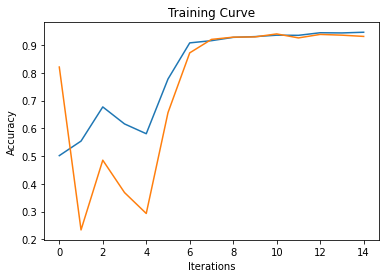

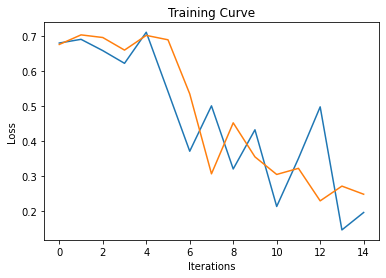

In [27]:
input_size = len(text_field.vocab.itos)
myModel = SpamDetectionRNN(input_size, hidden_size=50, num_classes=2)
trainRNN(myModel, train, valid, batch_size=64, num_epochs=15, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch: 1 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8609865470852018
Epoch: 2 , Training Accuracy: 0.6304095506549494 , Validation Accuracy: 0.3040358744394619
Epoch: 3 , Training Accuracy: 0.7073453821920079 , Validation Accuracy: 0.45022421524663675
Epoch: 4 , Training Accuracy: 0.5344055712153871 , Validation Accuracy: 0.14977578475336323
Epoch: 5 , Training Accuracy: 0.8006964019233958 , Validation Accuracy: 0.9408071748878923
Epoch: 6 , Training Accuracy: 0.930691427623943 , Validation Accuracy: 0.9130044843049328
Epoch: 7 , Training Accuracy: 0.9383186867849445 , Validation Accuracy: 0.9372197309417041
Epoch: 8 , Training Accuracy: 0.9421323163654453 , Validation Accuracy: 0.9434977578475336
Epoch: 9 , Training Accuracy: 0.9404742165478361 , Validation Accuracy: 0.9452914798206278
Epoch: 10 , Training Accuracy: 0.9447852760736196 , Validation Accuracy: 0.947085201793722
Epoch: 11 , Training Accuracy: 0.9418006964019234 , Validation Accuracy: 0.94977578475336

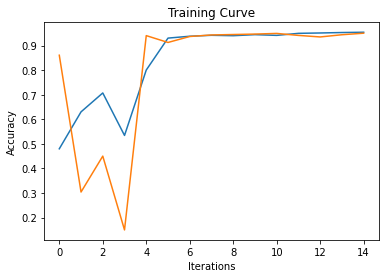

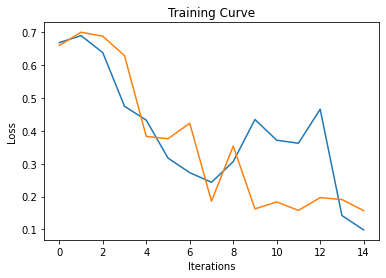

In [28]:
# Second model
# Here I will be increasing the number of hidden_size, but keeping everything else consistent
# Reasoning: Hoping to see more steady results and greater accuracy
# hidden_size = 100, num_classes = 2
# batch_size = 64, num_epochs = 15, learning_rate = 1e-4
input_size = len(text_field.vocab.itos)
mySecondModel = SpamDetectionRNN(input_size, hidden_size=100, num_classes=2)
trainRNN(mySecondModel, train, valid, batch_size=64, num_epochs=15, learning_rate=1e-4)

Epoch: 1 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 2 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 3 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 4 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 5 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 6 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 7 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 8 , Training Accuracy: 0.4820096169789421 , Validation Accuracy: 0.8654708520179372
Epoch: 9 , Training Accuracy: 0.507710164151882 , Validation Accuracy: 0.8663677130044843
Epoch: 10 , Training Accuracy: 0.5909467749958548 , Validation Accuracy: 0.873542600896861
Epoch: 11 , Training Accuracy: 0.7230973304592937 , Validation Accuracy: 0.8977578475336323

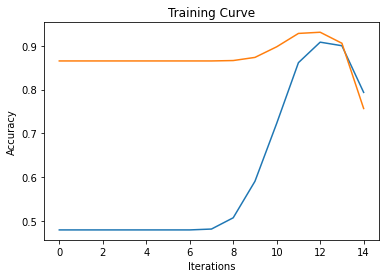

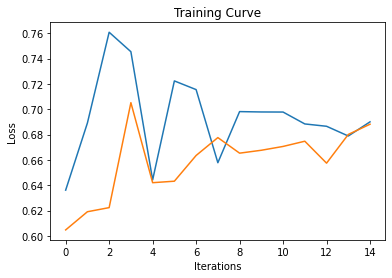

In [34]:
# Third model
# Here I will be increasing the learning rate, but keeping everything else consistent
# I was satisfied with my 100 hidden size
# Reasoning: Hoping to see more steady validation results and less error for my training
# hidden_size = 100, num_classes = 2
# batch_size = 64, num_epochs = 15, learning_rate = 1e-5
input_size = len(text_field.vocab.itos)
myThirdModel = SpamDetectionRNN(input_size, hidden_size=100, num_classes=2)
trainRNN(myThirdModel, train, valid, batch_size=64, num_epochs=15, learning_rate=1e-5)

Epoch: 1 , Training Accuracy: 0.5332449013430609 , Validation Accuracy: 0.14618834080717488
Epoch: 2 , Training Accuracy: 0.5231304924556458 , Validation Accuracy: 0.13811659192825113
Epoch: 3 , Training Accuracy: 0.5199801028021886 , Validation Accuracy: 0.13452914798206278
Epoch: 4 , Training Accuracy: 0.7453158680152545 , Validation Accuracy: 0.6269058295964126
Epoch: 5 , Training Accuracy: 0.6105123528436411 , Validation Accuracy: 0.3847533632286996
Epoch: 6 , Training Accuracy: 0.8804510031503896 , Validation Accuracy: 0.8681614349775785
Epoch: 7 , Training Accuracy: 0.8831039628585641 , Validation Accuracy: 0.8448430493273542
Epoch: 8 , Training Accuracy: 0.9132813795390482 , Validation Accuracy: 0.8986547085201794
Epoch: 9 , Training Accuracy: 0.9139446194660918 , Validation Accuracy: 0.9452914798206278
Epoch: 10 , Training Accuracy: 0.8884098822749129 , Validation Accuracy: 0.9426008968609866
Epoch: 11 , Training Accuracy: 0.8920577018736527 , Validation Accuracy: 0.95156950672

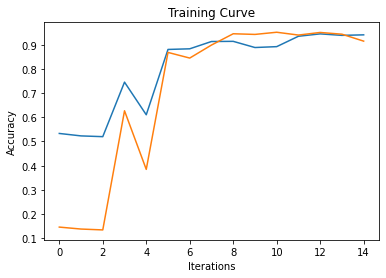

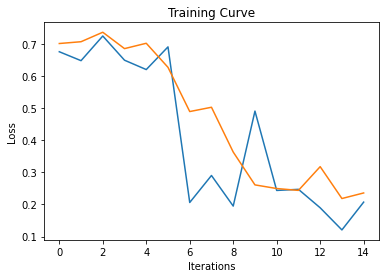

In [33]:
# Fourth model
# Here I will be changing the learning rate back to 1e-4 and increasing batch size to 100, but keeping everything else consistent
# I was not satisfied with my 1e-5 learning rate, so I'm reverting
# Reasoning: Hoping to see more steady validation results and less error for my training
# hidden_size = 100, num_classes = 2
# batch_size = 100, num_epochs = 15, learning_rate = 1e-4
input_size = len(text_field.vocab.itos)
myFourthModel = SpamDetectionRNN(input_size, hidden_size=100, num_classes=2)
trainRNN(myFourthModel, train, valid, batch_size=100, num_epochs=15, learning_rate=1e-4)

Epoch: 1 , Training Accuracy: 0.5221356325650804 , Validation Accuracy: 0.13991031390134528
Epoch: 2 , Training Accuracy: 0.9172608191013099 , Validation Accuracy: 0.9022421524663677
Epoch: 3 , Training Accuracy: 0.927209418006964 , Validation Accuracy: 0.9363228699551569
Epoch: 4 , Training Accuracy: 0.9439562261648151 , Validation Accuracy: 0.9533632286995516
Epoch: 5 , Training Accuracy: 0.9454485160006633 , Validation Accuracy: 0.9551569506726457
Epoch: 6 , Training Accuracy: 0.9608688443044271 , Validation Accuracy: 0.947085201793722
Epoch: 7 , Training Accuracy: 0.9577184546509699 , Validation Accuracy: 0.9300448430493273
Epoch: 8 , Training Accuracy: 0.9656773337754933 , Validation Accuracy: 0.95695067264574
Epoch: 9 , Training Accuracy: 0.85292654617808 , Validation Accuracy: 0.7318385650224215
Epoch: 10 , Training Accuracy: 0.9630243740673189 , Validation Accuracy: 0.9605381165919282
Epoch: 11 , Training Accuracy: 0.9626927541037971 , Validation Accuracy: 0.9363228699551569
Ep

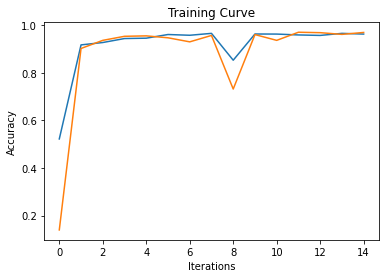

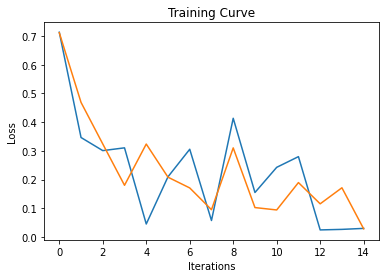

In [32]:
# Fifth model
# Here I will be changing the batch size to 32, but keeping everything else consistent
# I was not satisfied with my batch size of 100, so I'm changing to something lower
# Reasoning: Hoping to see more steady validation results and less error for my training
# hidden_size = 100, num_classes = 2
# batch_size = 32, num_epochs = 15, learning_rate = 1e-4
input_size = len(text_field.vocab.itos)
myFifthModel = SpamDetectionRNN(input_size, hidden_size=100, num_classes=2)
trainRNN(myFifthModel, train, valid, batch_size=32, num_epochs=15, learning_rate=1e-4)

Per my results, I'm most satisfied with my fifth model. The accuracy training and validation curves are almost identical and steady and the loss curves are respectable as well. The highest validation accuracy I achieved was 97.0%.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [36]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = None # TODO
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

falsePositiveRate = 1 - get_accuracy(myFifthModel, valid_nospam, 32)
falseNegativeRate = 1 - get_accuracy(myFifthModel, valid_spam, 32)

print("My final model's false positive rate across the validation set is:", falsePositiveRate*100, "%")
print("My final model's false negative rate across the validation set is:", falseNegativeRate*100, "%")

My final model's false positive rate across the validation set is: 2.1761658031088094 %
My final model's false negative rate across the validation set is: 6.000000000000005 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false positive has the effect of causing the user's phone to mistakenly identify spam content as non-spam. The user will find this annoying because the spam mails will still get through and reach them.

False negatives have the effect of causing the user's phone to mistakenly identify non-spam material as spam and prohibit the user from receiving it. This could be a concern since it might prevent the user from seeing potentially crucial information, which might irritate the user.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [37]:
finalTestAccuracy = get_accuracy(myFifthModel, test, 32)
print("The final test accuracy is:", finalTestAccuracy*100, "%")

The final test accuracy is: 97.66606822262118 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [38]:
# Create a Dataset of only spam testing examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam testing examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

falsePositiveRate = 1 - get_accuracy(myFifthModel, test_nospam, 32)
falseNegativeRate = 1 - get_accuracy(myFifthModel, test_spam, 32)

print("My final model's false positive rate across the testing set is:", falsePositiveRate*100, "%")
print("My final model's false negative rate across the testing set is:", falseNegativeRate*100, "%")

My final model's false positive rate across the testing set is: 1.865284974093262 %
My final model's false negative rate across the testing set is: 6.040268456375841 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [40]:
msg = "machine learning is sooo cool!"

msg_index = []

for i in msg:
  idx = text_field.vocab.stoi[i]
  msg_index.append(idx)

msg_tensor = torch.tensor(msg_index).unsqueeze(0)
prediction = myFifthModel(msg_tensor)
prediction = F.softmax(prediction, dim=1)

print(prediction)

tensor([[0.9703, 0.0297]], grad_fn=<SoftmaxBackward>)


My model confidently predicts that the probability that the msg, "machine learning is sooo cool!", is spam is 2.97%. Therefore, I think my model predicts well because evidently using human intuition, this isn't a spam message so to render such a low spam probability is a good indicator that my model can correctly classify messages.

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I believe that it is difficult to detect spam. This is due to the fact that spam can take many different forms. Although I had a testing accuracy of 97% in detecting spam, there are still a lot of false positives and false negatives. Although this percentage might not seem like much, it could be quite significant to attain lower error rates, especially for more vital work. Furthermore, spam messages are always changing, thus it might be challenging for my algorithm to identify variations and adaptations. Hackers and scammers adapt their spam messages to make them seem realistic to bypass AI model detection.

Based on the existing data, my baseline model would be very basic and predict if the message is spam or not. For instance, our data shows that there were 747 spam mails and 4827 non-spam communications. In order to obtain an accuracy of 86.6%, my model would therefore always predict that the message is not spam. Additionally, I would check the message to see whether it contains any of the words I have hard-coded into my algorithm, and if it does, I would immediately designate the message as spam. I would reach an accuracy in the upper 80s with this combo, which is excellent for a baseline model. Then I may evaluate this model against my own. As opposed to this model, which is entirely guessing and uses little "machine learning," my model ought to perform better. I would know that my model is not the greatest if it performed worse than this model. Any machine learning model can be compared to this baseline model as a reasonable benchmark.

In [43]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/APS360/Lab5 Spam Detection - Shadman Kaif.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/APS360/Lab5 Spam Detection - Shadman Kaif.ipynb to html
[NbConvertApp] Writing 603147 bytes to /content/drive/MyDrive/Colab Notebooks/APS360/Lab5 Spam Detection - Shadman Kaif.html
